In [8]:
import json
import pandas as pd
import numpy as np
import string
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#### Loading Question-Answer data

In [9]:
filename = "D:\\WebScience\\web_science_dataset.jsonl"
json_data = []
json_data_list = []


with open(filename) as f:
    json_data = f.readlines()
    
for item in json_data:
    json_data_list.append(json.loads(item))
    
df = pd.DataFrame(json_data_list)
df.head()

question_df = pd.DataFrame(df[['question','questionId','category','categoryId']])
question_df.head()

,question,questionId,category,categoryId
0,Can headbanging cause brain damage?,14138,medical-science,2
1,Does the Shangri-La diet work (according to it...,10103,nutrition,0
2,"Can phobias be genetic, but created in one gen...",18713,psychology,4
3,Do 40% of U.S. Americans think that global war...,36010,climate-change,1
4,Does boiling the same water twice make it dang...,11118,nutrition,0


## Preprocess Text

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [11]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return (' '.join(lemmatizer.lemmatize(w) for w in word_tokenize(text)))

In [12]:
def preprocess_text(df):    
    
    # convert to lowercase
    df = df.str.lower()
    
    # remove punctuation
    translator = str.maketrans('', '', string.punctuation) 
    df = df.str.translate(translator)
    
    # remove non-alphanumeric characters
    #'\W+' = '[^a-zA-Z0-9_]'
    #df = df.re.sub(r'\W+','')
    #df = df.replace(to_replace ='\s*[^A-Za-z]+\s*', value = ' ', regex = True)
    
    # remove digits
    translator = str.maketrans('', '', string.digits) 
    df = df.str.translate(translator)
    
    # remove leading/trailing whitespaces
    df = df.str.strip()
    
    #lemmatize
    df = df.apply(lemmatize_text)
    
    return df

## TFIDF vectors

In [13]:
question_df['question'] = preprocess_text(question_df['question'])

In [7]:
vectors = TfidfVectorizer().fit_transform(question_df['question'])

In [25]:
vectors[0].toarray()[0].shape

(3157,)

In [20]:
labels = np.array(list(question_df['categoryId']))

In [32]:
question_df.head()

,question,questionId,category,categoryId
0,can headbanging cause brain damage,14138,medical-science,2
1,doe the shangrila diet work according to it su...,10103,nutrition,0
2,can phobia be genetic but created in one gener...,18713,psychology,4
3,do of u american think that global warming is ...,36010,climate-change,1
4,doe boiling the same water twice make it dange...,11118,nutrition,0


## TSNE Visualization 

In [109]:
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(vectors)

In [122]:
X_embedded = TSNE(n_components=2, perplexity=50, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1066 samples in 0.003s...
[t-SNE] Computed neighbors for 1066 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1066
[t-SNE] Computed conditional probabilities for sample 1066 / 1066
[t-SNE] Mean sigma: 0.177682
[t-SNE] Computed conditional probabilities in 0.068s
[t-SNE] Iteration 50: error = 71.8030319, gradient norm = 0.2852612 (50 iterations in 0.612s)
[t-SNE] Iteration 100: error = 73.2123184, gradient norm = 0.2584718 (50 iterations in 0.731s)
[t-SNE] Iteration 150: error = 71.6175461, gradient norm = 0.2730793 (50 iterations in 0.663s)
[t-SNE] Iteration 200: error = 72.3555450, gradient norm = 0.2739881 (50 iterations in 0.716s)
[t-SNE] Iteration 250: error = 74.3627396, gradient norm = 0.2345026 (50 iterations in 0.697s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.362740
[t-SNE] Iteration 300: error = 1.5154614, gradient norm = 0.0028051 (50 iterations in 0.581s

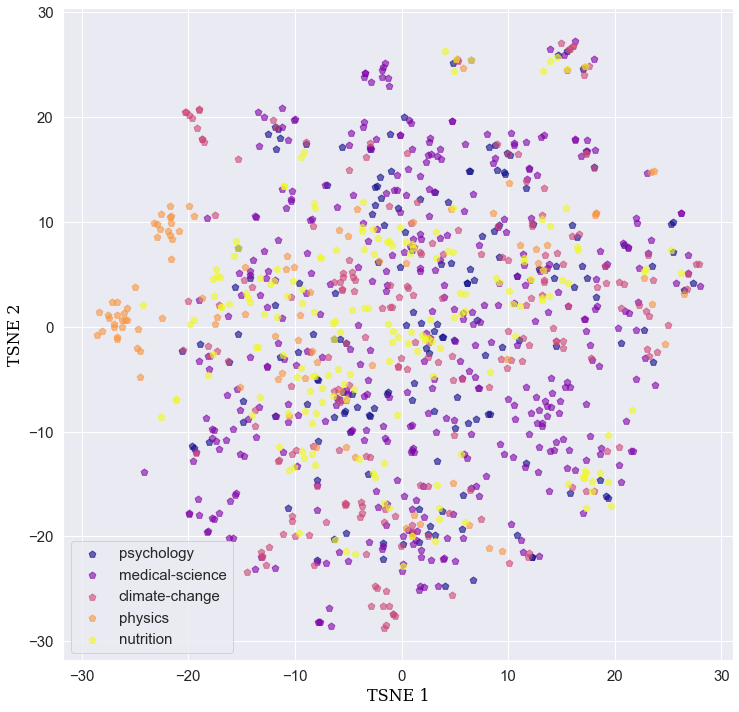

In [123]:
tsne_vals = pd.DataFrame(X_embedded,columns=['comp1','comp2'])
categories = pd.DataFrame(question_df['categoryId'],columns=['categoryId'])
combined_df = pd.concat([tsne_vals,categories],axis=1)
combined_df.head()

colors = list(combined_df['categoryId'].unique())
colormap = dict(zip(set(question_df['categoryId']),set(question_df['category'])))
clist = ['#0d0887', '#7e03a8', '#cc4778', '#f89540', '#f0f921']
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(12,12))
for i in range(0 , len(colors)):
    data = combined_df.loc[combined_df['categoryId'] == colors[i]]
    plt.scatter('comp1', 'comp2', data=data , c=clist[i], label=colormap[colors[i]], alpha=0.6, s=50,marker="p")
plt.legend(fontsize='x-large',prop={'size': 15, 'family': 'sans-serif'})
plt.grid(b=True,axis='both')
plt.xlabel('TSNE 1',fontdict=font)
plt.ylabel('TSNE 2',fontdict=font)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.show()